# Imports

## Libraries

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from transformers import pipeline
from datasets import load_dataset
import openai
import json
import os
import re
import random
import glob
import ast
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = openai_api_key

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device detected")

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import pandas as pd
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Torch version: 2.2.0+cu121
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


## Data

In [2]:
dataset = load_dataset("conll2003")

train_dataset = dataset['train']
test_dataset = dataset['test']
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 14041
Test dataset length: 3453


In [3]:
features = train_dataset.features
ner_tags = features['ner_tags'].feature.names

print("ner_tags:", ner_tags)

ner_tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [4]:
train_tokens = train_dataset['tokens']
train_ner_tags = train_dataset['ner_tags']

test_tokens = test_dataset['tokens']
test_ner_tags = test_dataset['ner_tags']

example_sentence = train_tokens[0]
example_ner_tags = train_ner_tags[0]

print("Example sentence:", example_sentence)
print("Example NER tags:", example_ner_tags)

Example sentence: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Example NER tags: [3, 0, 7, 0, 0, 0, 7, 0, 0]


## Models

### bert-base-NER

In [5]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using /root/.cache/torch_extensions/py311_cu121 as PyTo

In [6]:
def join_words(words):
    sentence = " ".join(words)
    sentence = re.sub(r'\s+([?.!,])', r'\1', sentence)
    return sentence.strip()

In [7]:
example_string_sentence = join_words(example_sentence)
ner_results = nlp(example_string_sentence)
print(ner_results)

[{'entity': 'B-ORG', 'score': 0.9993412, 'index': 1, 'word': 'EU', 'start': 0, 'end': 2}, {'entity': 'B-MISC', 'score': 0.99967873, 'index': 3, 'word': 'German', 'start': 11, 'end': 17}, {'entity': 'B-MISC', 'score': 0.99961346, 'index': 7, 'word': 'British', 'start': 34, 'end': 41}]


### gpt-4o-mini

In [8]:
response = openai.ChatCompletion.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "Hello, how are you?"}
    ]
)

# Print the response
print(response.choices[0].message.content)

Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


# Processing

## BERT

In [9]:
def convert_ner_results_to_tags(ner_results, text, ner_tags):
    # Split text into words, handling all punctuation
    words = []
    for word in text.split():
        # Check if word ends with any punctuation
        if any(word.endswith(p) for p in '.,!?:;()[]{}"\'-') and len(word) > 1:
            # Split word and punctuation
            words.append(word[:-1])
            words.append(word[-1])
        else:
            words.append(word)
    
    # Initialize tags list with O (0) for all words
    tags = [0] * len(words)
    
    # For each entity found
    for result in ner_results:
        # Find the word index from the result's index (subtract 1 since model uses 1-based indexing)
        word_index = result['index'] - 1
        # Convert entity type to numeric tag using position in ner_tags list
        tag = ner_tags.index(result['entity']) if result['entity'] in ner_tags else 0
        if word_index >= 0 and word_index < len(tags):
            tags[word_index] = tag
            
    return tags

In [10]:
def process_sentence_bert(sentence):
    # Join words into a single string
    string_sentence = join_words(sentence)
    
    # Get NER predictions from BERT model
    ner_results = nlp(string_sentence)
    
    # Convert NER results to numeric tags
    bert_tags = convert_ner_results_to_tags(ner_results, string_sentence, ner_tags)
    
    return bert_tags, ner_results

In [11]:
bert_prediction, raw_results = process_sentence_bert(example_sentence)
print(bert_prediction)

[3, 0, 7, 0, 0, 0, 7, 0, 0]


## LLM

In [12]:
def extract_json(raw_output):
    try:
        # Use regex to extract the JSON array from the response
        json_match = re.search(r'\[.*\]', raw_output, re.DOTALL)
        if json_match:
            return json_match.group(0)  # Return the matched JSON string
        else:
            raise ValueError("No JSON array found in the output.")
    except Exception as e:
        raise ValueError(f"Error extracting JSON: {e}")


def generate_examples(n, train_sentences, train_ground_truth_tags, shuffle=False, format_sentence=True):
    """
    Generate example input for NER tagging with dynamic examples.

    Parameters:
      - n (int): Number of examples to include.
      - train_sentences (list of list of str): List of tokenized sentences.
      - train_ground_truth_tags (list of list of str): List of corresponding NER tags for each sentence.
      - shuffle (bool): Whether to shuffle the examples before selecting.
      - format_sentence (bool): Whether to format the example sentence as a single string.

    Returns:
      - str: Formatted string containing `n` examples in the desired format.
    """
    # Define NER tag mapping
    ner_tag_map = {
        '0': 'O',
        '1': 'B-PER',
        '2': 'I-PER',
        '3': 'B-ORG', 
        '4': 'I-ORG',
        '5': 'B-LOC',
        '6': 'I-LOC',
        '7': 'B-MISC',
        '8': 'I-MISC'
    }
    
    # Pair sentences with their corresponding tags
    examples = list(zip(train_sentences, train_ground_truth_tags))
    
    # Shuffle examples if specified
    if shuffle:
        random.shuffle(examples)
    
    # Select the first n examples
    selected_examples = examples[:n]
    
    # Format the selected examples into the desired output structure
    formatted_examples = []
    for sentence, tags in selected_examples:
        if format_sentence:
            # Join tokens into a single formatted sentence
            formatted_sentence = join_words(sentence)
        else:
            # Keep sentence as a list
            formatted_sentence = sentence
        
        # Format each word-tag pair into JSON-like structure, converting numeric tags to labels
        formatted_output = [
            f'{{"word": "{word}", "entity": "{ner_tag_map.get(str(tag), "O")}"}}' 
            for word, tag in zip(sentence, tags)
        ]
        
        # Combine sentence and tags into an example
        formatted_example = (
            f"Sentence: \"{formatted_sentence}\" "
            f"Output: ["
            + ",".join(formatted_output) + 
            f"]"
        )
        
        # Append to list of formatted examples
        formatted_examples.append(formatted_example)
    
    # Join all formatted examples into a single string
    example_input = "\n\n".join(formatted_examples)
    
    return example_input


def ner_tag_sentence(sentence, train_sentences, train_ground_truth_tags, examples_provided=0, preprocess=False, track_responses=None, formatted_sentence=True):
    """
    Perform NER tagging on a given sentence using provided training examples.

    Parameters:
      - sentence (str): The sentence to tag.
      - train_sentences (list of list of str): List of tokenized sentences for training examples.
      - train_ground_truth_tags (list of list of str): Corresponding NER tags for training sentences.
      - examples_provided (int): Number of training examples to include in the prompt.
      - preprocess (bool): Whether to preprocess the model's raw output.
      - track_responses (list): Optional list to track responses from the model.
      - formatted_sentence (bool): Whether to format sentences as strings.

    Returns:
      - dict: Parsed JSON response from the model or an error message.
    """
    logging.debug(f"NER tagging sentence: \"{sentence}\" with {examples_provided} examples.")
    
    # Define the NER tags with their descriptions
    ner_labels = {
        "O": "No entity",
        "B-PER": "Beginning of person name",
        "I-PER": "Inside of person name", 
        "B-ORG": "Beginning of organization",
        "I-ORG": "Inside of organization",
        "B-LOC": "Beginning of location",
        "I-LOC": "Inside of location",
        "B-MISC": "Beginning of miscellaneous entity",
        "I-MISC": "Inside of miscellaneous entity"
    }

    # Define reverse mapping from labels to IDs
    label_to_id = {
        'O': '0',
        'B-PER': '1',
        'I-PER': '2',
        'B-ORG': '3',
        'I-ORG': '4',
        'B-LOC': '5',
        'I-LOC': '6',
        'B-MISC': '7',
        'I-MISC': '8'
    }

    # Generate example input for the model
    example_input = generate_examples(examples_provided, train_sentences, train_ground_truth_tags, shuffle=True, format_sentence=formatted_sentence)

    # Construct the prompt with instructions for NER tagging
    prompt = (
        f"Perform Named Entity Recognition (NER) tagging on the following sentence using these labels: {ner_labels}. "
        f"These are examples of other sentences properly tagged: {example_input}\n\n"
        f"Don't include any explanation, just output each word with its entity tag in JSON format of the following sentence.\n\nSentence: \"{sentence}\""
    )
    
    logging.debug(f"Constructed prompt:\n{prompt}")

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        raw_output = response.choices[0].message.content.strip()
        
        logging.debug(f"Raw output from model:\n{raw_output}")
        
        cleaned_output = extract_json(raw_output)
        
        try:
            parsed_json = json.loads(cleaned_output)
            # Convert entity labels back to IDs
            for item in parsed_json:
                item['entity'] = label_to_id.get(item['entity'], '0')
            logging.debug(f"Parsed JSON output:\n{parsed_json}")
        except json.JSONDecodeError:
            parsed_json = {"error": "Response could not be parsed as JSON", "raw_output": raw_output}
            logging.error("Failed to parse JSON output.")
        
        if track_responses is not None:
            track_responses.append({"raw_response": raw_output, "parsed_json": parsed_json})
        
        return parsed_json
    
    except Exception as e:
        logging.error(f"Error during API call or processing: {e}")
        return {"error": str(e)}


def process_sentence_llm(sentence, train_sentences, train_ground_truth_tags, examples_provided=0, format_sentence=True):
    """
    Processes a sentence to extract NER tags while tracking responses.

    Args:
      - sentence (str): The input sentence to process.
      - train_sentences (list of list of str): List of tokenized sentences for training examples.
      - train_ground_truth_tags (list of list of str): Corresponding NER tags for training sentences.
      - examples_provided (int): Number of training examples provided for context (default is 0).
      - format_sentence (bool): Whether to format sentences as strings.

    Returns:
      - tuple: A tuple containing a list of NER tags (or an empty list if retrieval fails) 
               and the response log.
    """
    responses_log = []  # Initialize the log

    try:
        if format_sentence:
            sentence = join_words(sentence)

        ner_tags_json = ner_tag_sentence(
            sentence,
            train_sentences,
            train_ground_truth_tags,
            track_responses=responses_log,
            examples_provided=examples_provided,
            formatted_sentence=format_sentence
        )
        
        if isinstance(ner_tags_json, list) and all(isinstance(item, dict) and 'entity' in item for item in ner_tags_json):
            model_prediction = [int(item['entity']) for item in ner_tags_json]  # Convert string IDs to integers
        else:
            model_prediction = []
            logging.warning(f"Unexpected structure for ner_tags_json: {ner_tags_json}")
    
    except Exception as e:
        model_prediction = []
        logging.error(f"Error processing sentence: {e}")
    
    return model_prediction, responses_log

In [13]:
llm_prediction, llm_response = process_sentence_llm(example_sentence, train_tokens, train_ner_tags, examples_provided=3, format_sentence=False)
print(llm_prediction)

[3, 0, 5, 0, 0, 0, 5, 0, 0]


# Evaluation

## Example

In [14]:
print(example_sentence)

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


In [15]:
print(example_ner_tags)

[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [16]:
print(bert_prediction)

[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [17]:
print(llm_prediction)

[3, 0, 5, 0, 0, 0, 5, 0, 0]


## Full Test

In [18]:
def evaluate_predictions(sentences, ground_truth_tags, model_type="bert", train_data=None, examples_provided=None, format_sentence=False, output_csv="evaluation_results.csv"):
    """
    Evaluates predictions from either BERT or LLM model against ground truth POS tags and stores results in a CSV file.

    Args:
        sentences (list): A list of tokenized sentences.
        ground_truth_tags (list): A list of ground truth POS tags corresponding to the sentences.
        model_type (str): Type of model to evaluate ("bert" or "llm").
        train_data (tuple): Tuple of (train_sentences, train_ground_truth_tags) for LLM context.
        examples_provided (int): Number of examples provided to the LLM for context.
        format_sentence (bool): Whether to format sentences as strings.
        output_csv (str): Path to the CSV file where results will be stored.

    Returns:
        pd.DataFrame: A DataFrame containing evaluation results.
    """
    # Initialize lists for DataFrame columns
    total_words = []
    raw_predictions = []
    predictions = []
    successes_list = []
    prediction_lengths = []

    # Define column names based on model type
    model_prefix = f"llm_{examples_provided}" if model_type == "llm" else "bert"
    columns = [
        'sentences', 'ground_truth', 'total_words',
        f'{model_prefix}_raw', f'{model_prefix}_prediction',
        f'{model_prefix}_successes', f'{model_prefix}_prediction_length'
    ]

    # Check if the CSV file exists
    if not os.path.exists(output_csv):
        pd.DataFrame(columns=columns).to_csv(output_csv, index=False)

    # Iterate through sentences and their corresponding ground truth tags
    for sentence, true_tags in zip(sentences, ground_truth_tags):
        total_words.append(len(sentence))

        # Get predictions based on model type
        if model_type == "llm":
            if train_data is None:
                raise ValueError("train_data must be provided for LLM evaluation")
            train_sentences, train_ground_truth_tags = train_data
            prediction, raw = process_sentence_llm(
                sentence,
                train_sentences,
                train_ground_truth_tags,
                examples_provided=examples_provided,
                format_sentence=format_sentence
            )
        else:  # BERT
            prediction, raw = process_sentence_bert(sentence)

        raw_predictions.append(raw)
        predictions.append(prediction)
        prediction_lengths.append(len(prediction))

        # Calculate successes
        successes = sum([1 for pred, true in zip(prediction, true_tags) if pred == true])
        successes_list.append(successes)

        # Append the current iteration's results to the CSV file
        iteration_results = pd.DataFrame({
            'sentences': [sentence],
            'ground_truth': [true_tags],
            'total_words': [len(sentence)],
            f'{model_prefix}_raw': [raw],
            f'{model_prefix}_prediction': [prediction],
            f'{model_prefix}_successes': [successes],
            f'{model_prefix}_prediction_length': [len(prediction)]
        })

        iteration_results.to_csv(output_csv, mode='a', header=False, index=False)

    # Create final DataFrame
    results = {
        'sentences': sentences,
        'ground_truth': ground_truth_tags,
        'total_words': total_words,
        f'{model_prefix}_raw': raw_predictions,
        f'{model_prefix}_prediction': predictions,
        f'{model_prefix}_successes': successes_list,
        f'{model_prefix}_prediction_length': prediction_lengths
    }

    return pd.DataFrame(results)

bert-base-NER

In [19]:
bert_results_file = "/text-mining/03_name_entity_recognition/03_bert_results.csv"
bert_results = evaluate_predictions(test_tokens, test_ner_tags, model_type="bert",output_csv=bert_results_file)
bert_results = pd.read_csv(bert_results_file)
bert_results.shape

(3453, 7)

gpt-4o-mini

In [20]:
format_sentence=False

In [21]:
examples_provided=1

llm_results_file = f"/text-mining/03_name_entity_recognition/03_llm_results_{examples_provided}_examples.csv"
llm_results = evaluate_predictions(test_tokens, test_ner_tags, model_type="llm", train_data=(train_tokens, train_ner_tags), examples_provided=examples_provided, format_sentence=False, output_csv=llm_results_file)
llm_results = pd.read_csv(llm_results_file)
llm_results.shape

2025-02-09 15:00:48,367 - ERROR - Failed to parse JSON output.
2025-02-09 15:00:48,367 - WARNING - Unexpected structure for ner_tags_json: {'error': 'Response could not be parsed as JSON', 'raw_output': '[{"word": "However", "entity": "O"},{"word": ",", "entity": "O"},{"word": "we", "entity": "O"},{"word": "are", "entity": "O"},{"word": "assuming", "entity": "O"},{"word": "they", "entity": "O"},{"word": "are", "entity": "O"},{"word": "as", "entity": "O"},{"word": "a", "entity": "O"},{"word": "precaution", "entity": "O"},{"word": "for", "entity": "O"},{"word": "the", "entity": "O"},{"word": "time", "entity": "O"},{"word": "being", "entity": "O"},{"word": ",", "entity": "O"},{"word": \'"\', "entity": "O"},{"word": "a", "entity": "O"},{"word": "spokeswoman", "entity": "O"},{"word": "said", "entity": "O"},{"word": ".", "entity": "O"}]'}
2025-02-09 15:21:22,647 - ERROR - Failed to parse JSON output.
2025-02-09 15:21:22,648 - WARNING - Unexpected structure for ner_tags_json: {'error': 'Respo

(3453, 7)

In [22]:
examples_provided=3

llm_results_file = f"/text-mining/03_name_entity_recognition/03_llm_results_{examples_provided}_examples.csv"
llm_results = evaluate_predictions(test_tokens, test_ner_tags, model_type="llm", train_data=(train_tokens, train_ner_tags), examples_provided=examples_provided, format_sentence=False, output_csv=llm_results_file)
llm_results = pd.read_csv(llm_results_file)
llm_results.shape

2025-02-09 18:19:39,092 - ERROR - Failed to parse JSON output.
2025-02-09 18:19:39,092 - WARNING - Unexpected structure for ner_tags_json: {'error': 'Response could not be parsed as JSON', 'raw_output': '[{"word": """, "entity": "O"}, {"word": "The", "entity": "O"}, {"word": "nomination", "entity": "O"}, {"word": "...", "entity": "O"}]'}
2025-02-09 18:25:22,524 - ERROR - Failed to parse JSON output.
2025-02-09 18:25:22,524 - WARNING - Unexpected structure for ner_tags_json: {'error': 'Response could not be parsed as JSON', 'raw_output': '[{"word": """, "entity": "O"},{"word": "I", "entity": "O"},{"word": "think", "entity": "O"},{"word": "Polish", "entity": "B-MISC"},{"word": "consumers", "entity": "O"},{"word": "in", "entity": "O"},{"word": "general", "entity": "O"},{"word": "are", "entity": "O"},{"word": "quite", "entity": "O"},{"word": "proud", "entity": "O"},{"word": "of", "entity": "O"},{"word": "their", "entity": "O"},{"word": "beers", "entity": "O"},{"word": "--", "entity": "O"},

(3453, 7)

# Results

In [23]:
def plot_overall_accuracy(df, title="Overall Accuracy Comparison"):
    """
    Calculates overall accuracy for multiple models and plots a bar chart.

    Args:
        df (pd.DataFrame): A DataFrame with columns 'total_words' and '*_successes' for each model.
        title (str): The title of the plot. Defaults to "Overall Accuracy Comparison".

    Returns:
        None: Displays a bar plot of overall accuracies.
    """
    # Get total words
    total_words = df['total_words'].sum()
    
    # Find all success columns
    success_cols = [col for col in df.columns if col.endswith('_successes')]
    
    # Calculate accuracies for each model
    accuracies = []
    labels = []
    for col in success_cols:
        total_successes = df[col].sum()
        accuracy = total_successes / total_words
        accuracies.append(accuracy)
        # Create label from column name (remove _successes)
        model_name = col.replace('_successes', '').upper()
        labels.append(f'{model_name} Accuracy')

    # Plot the bar chart
    plt.figure(figsize=(10, 6))  # Slightly wider to accommodate more bars
    colors = plt.cm.tab20(np.linspace(0, 1, len(accuracies)))  # Generate colors based on number of models
    plt.bar(labels, accuracies, color=colors)
    
    # Add labels and title
    plt.ylabel('Accuracy')
    plt.title(title)
    
    # Rotate labels if there are many models
    if len(labels) > 3:
        plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.ylim(0, 1)  # Ensure y-axis is between 0 and 1 for accuracy
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [24]:
def plot_prediction_length_accuracy(df, title="Prediction Length Accuracy"):
    """
    Plots a bar chart comparing the prediction length accuracy for each model.
    
    Args:
        df (pd.DataFrame): DataFrame containing prediction length columns and total_words
        title (str): Title for the plot. Defaults to "Prediction Length Accuracy"
        
    Returns:
        None: Displays a bar plot of prediction length accuracies
    """
    # Get total number of samples
    total_samples = len(df)
    
    # Find all prediction length columns
    pred_length_cols = [col for col in df.columns if col.endswith('_prediction_length')]
    
    # Calculate accuracies
    accuracies = []
    labels = []
    for col in pred_length_cols:
        # Count how many predictions match total words
        matches = (df[col] == df['total_words']).sum()
        accuracy = matches / total_samples
        accuracies.append(accuracy)
        # Create label from column name
        model_name = col.replace('_prediction_length', '').upper()
        labels.append(f'{model_name}')
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(accuracies)))
    plt.bar(labels, accuracies, color=colors)
    
    # Add labels and title
    plt.ylabel('Accuracy')
    plt.title(title)
    
    # Rotate labels if there are many models
    if len(labels) > 3:
        plt.xticks(rotation=45, ha='right')
    
    # Set y-axis limits and add percentage labels
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [25]:
def load_and_merge_results(folder_path):
    """
    Loads and merges all BERT and LLM results CSV files from a folder.
    
    Args:
        folder_path (str): Path to folder containing the CSV files
        
    Returns:
        pd.DataFrame: Merged results with duplicate columns removed
    """
    # Get list of all CSV files in the folder
    csv_files = glob.glob(f"{folder_path}/*.csv")
    
    # Separate BERT and LLM results files
    bert_files = [f for f in csv_files if 'bert' in f.lower()]
    llm_files = [f for f in csv_files if 'llm' in f.lower()]
    
    # Read BERT results
    bert_results = pd.read_csv(bert_files[0])
    
    # Read and merge LLM results
    llm_dfs = []
    for f in llm_files:
        df = pd.read_csv(f)
        # Extract LLM number from filename (e.g. llm_1 or llm_3)
        llm_num = f.split('_')[-2]
        # Rename columns to include LLM number
        df = df.rename(columns={
            'llm_prediction': f'llm_{llm_num}_prediction',
            'llm_successes': f'llm_{llm_num}_successes',
            'llm_prediction_length': f'llm_{llm_num}_prediction_length'
        })
        llm_dfs.append(df)
    
    # Merge all results
    results = bert_results
    for llm_df in llm_dfs:
        # Keep only the unique columns from LLM results
        llm_cols = [col for col in llm_df.columns if col not in ['sentences', 'ground_truth', 'total_words']]
        results = pd.merge(results, llm_df[llm_cols], left_index=True, right_index=True)
            
    return results

In [26]:
results = load_and_merge_results("/text-mining/03_name_entity_recognition/")
results.shape

(3453, 15)

In [27]:
results.head()

,sentences,ground_truth,total_words,bert_raw,bert_prediction,bert_successes,bert_prediction_length,llm_1_raw,llm_1_prediction,llm_1_successes,llm_1_prediction_length,llm_3_raw,llm_3_prediction,llm_3_successes,llm_3_prediction_length
0,"['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN'...","[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]",12,"[{'entity': 'B-MISC', 'score': 0.4801418, 'ind...","[0, 0, 0, 0, 0, 7, 6, 0, 0, 0, 1, 6]",6,12,"[{'raw_response': '[{""word"": ""SOCCER"", ""entity...","[0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]",11,12,"[{'raw_response': '[{""word"": ""SOCCER"", ""entity...","[7, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]",10,12
1,"['Nadim', 'Ladki']","[1, 2]",2,"[{'entity': 'B-PER', 'score': 0.99730563, 'ind...","[1, 1]",1,2,"[{'raw_response': '[{""word"": ""Nadim"", ""entity""...","[1, 2]",2,2,"[{'raw_response': '[{""word"": ""Nadim"", ""entity""...","[1, 2]",2,2
2,"['AL-AIN', ',', 'United', 'Arab', 'Emirates', ...","[5, 0, 5, 6, 6, 0]",6,"[{'entity': 'B-LOC', 'score': 0.9976654, 'inde...","[5, 6, 6, 6, 0, 5]",2,6,"[{'raw_response': '[{""word"": ""AL-AIN"", ""entity...","[5, 0, 3, 4, 4, 0]",3,6,"[{'raw_response': '[{""word"":""AL-AIN"",""entity"":...","[5, 0, 3, 4, 4, 0]",3,6
3,"['Japan', 'began', 'the', 'defence', 'of', 'th...","[5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...",25,"[{'entity': 'B-LOC', 'score': 0.9998572, 'inde...","[5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...",21,25,"[{'raw_response': '[{""word"": ""Japan"", ""entity""...","[5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...",22,25,"[{'raw_response': '[{""word"": ""Japan"", ""entity""...","[5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...",23,25
4,"['But', 'China', 'saw', 'their', 'luck', 'dese...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",25,"[{'entity': 'B-LOC', 'score': 0.9998673, 'inde...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,25,"[{'raw_response': '[{""word"": ""But"", ""entity"": ...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",25,25,"[{'raw_response': '[{""word"": ""But"", ""entity"": ...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",25,25


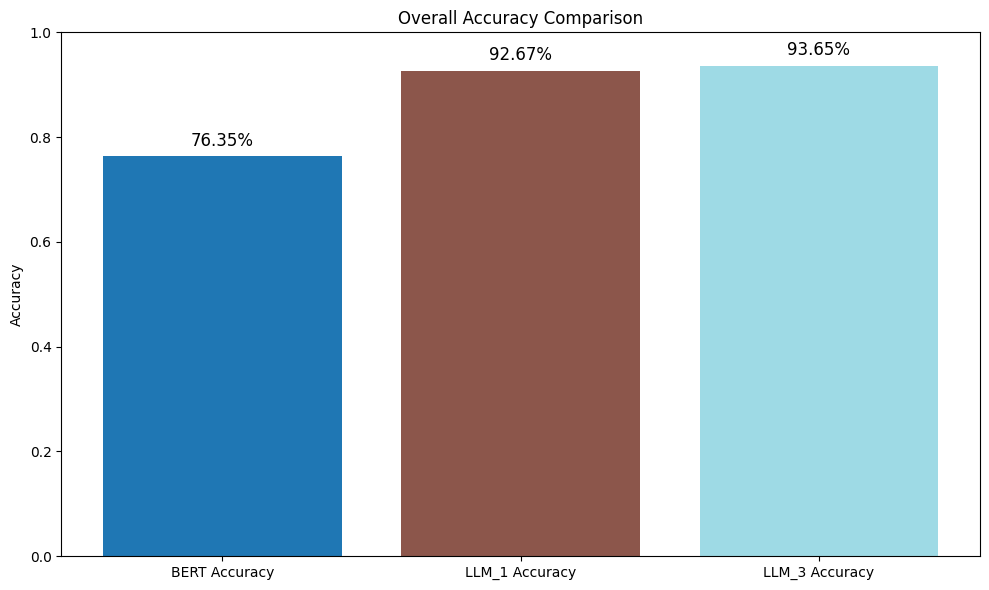

In [28]:
plot_overall_accuracy(results)

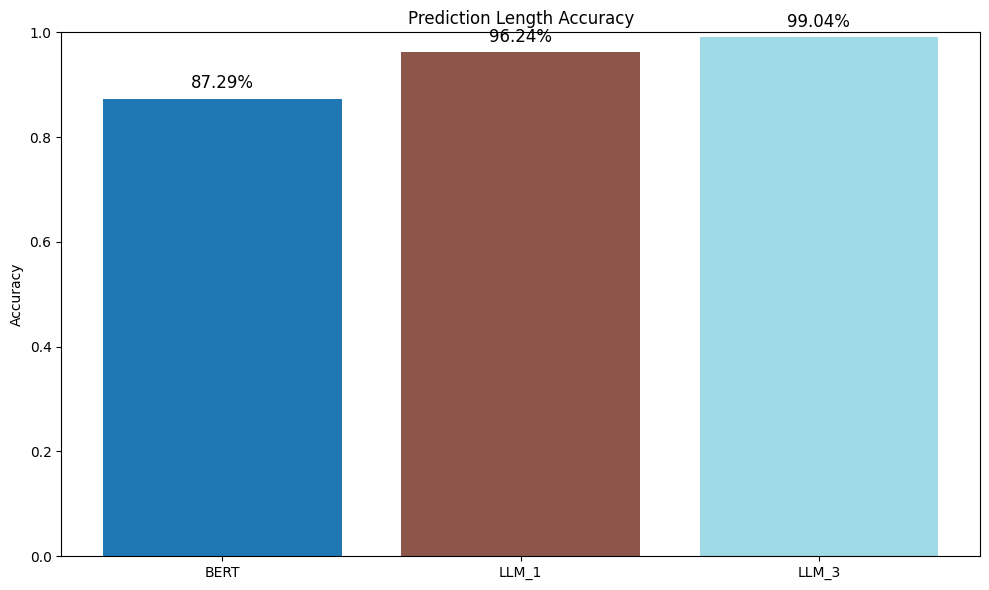

In [29]:
plot_prediction_length_accuracy(results)


## All tokens identified

In [30]:
def filter_matching_predictions(df):
    """
    Filters dataframe to keep only rows where all prediction lengths match total_words.
    
    Args:
        df (pd.DataFrame): DataFrame containing prediction columns ending with '_prediction_length'
        
    Returns:
        pd.DataFrame: Filtered DataFrame where all prediction lengths match total_words
    """
    # Get all columns that end with 'prediction_length'
    prediction_length_cols = [col for col in df.columns if col.endswith('prediction_length')]
    
    # Create a condition that checks if total_words equals each prediction length
    conditions = [df['total_words'] == df[col] for col in prediction_length_cols]
    
    # Combine all conditions with & operator
    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition & condition
        
    return df[final_condition]

filtered_df = filter_matching_predictions(results)
filtered_df.shape

(2874, 15)

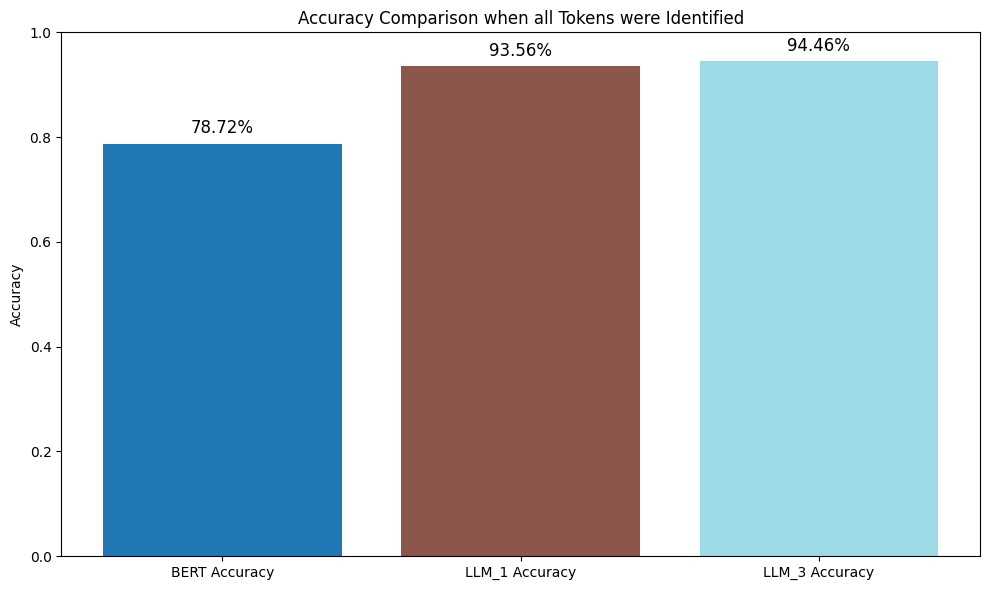

In [31]:
plot_overall_accuracy(filtered_df, title="Accuracy Comparison when all Tokens were Identified")

In [32]:
def plot_failed_ner_tags(df):
    """
    Identifies the number of failures for each NER tag and plots a bar chart with multiple colors per bar.
    Dynamically handles any number of LLM prediction columns.

    Args:
        df (pd.DataFrame): A DataFrame with columns 'ground_truth', various '*_prediction' columns.

    Returns:
        None: Displays a bar plot of NER tag failures.
    """
    # Define NER tag mapping for readable labels
    ner_tag_map = {
        '0': 'O',
        '1': 'B-PER',
        '2': 'I-PER',
        '3': 'B-ORG', 
        '4': 'I-ORG',
        '5': 'B-LOC',
        '6': 'I-LOC',
        '7': 'B-MISC',
        '8': 'I-MISC'
    }

    # Find all prediction columns (excluding length and raw columns)
    pred_cols = [col for col in df.columns if col.endswith('_prediction') 
                and not col.endswith('_length') 
                and not col.endswith('_raw')]
    
    # Find corresponding length columns
    length_cols = [col.replace('prediction', 'prediction_length') for col in pred_cols]

    # Create length matching condition
    length_condition = df['total_words'] == df[length_cols[0]]
    for col in length_cols[1:]:
        length_condition = length_condition & (df['total_words'] == df[col])

    # Filter out rows where lengths don't match
    df = df[length_condition]

    # Initialize dictionary for predictions
    all_predictions = {
        'ground_truth': []
    }
    for col in pred_cols:
        all_predictions[col] = []

    # Flatten lists
    for row in df.itertuples(index=False):
        # Parse ground truth
        ground_truth_list = ast.literal_eval(row.ground_truth)
        all_predictions['ground_truth'].extend(ground_truth_list)
        
        # Parse predictions for each model
        for col in pred_cols:
            pred_list = ast.literal_eval(getattr(row, col))
            all_predictions[col].extend(pred_list)

    # Create analysis DataFrame
    analysis_df = pd.DataFrame(all_predictions)

    # Calculate failures for each model
    failure_cols = []
    for col in pred_cols:
        failure_col = f"{col.replace('prediction', 'failure')}"
        analysis_df[failure_col] = analysis_df['ground_truth'] != analysis_df[col]
        failure_cols.append(failure_col)

    # Count failures for each NER tag
    agg_dict = {col: 'sum' for col in failure_cols}
    failure_counts = analysis_df.groupby('ground_truth').agg(agg_dict).reset_index()

    # Add total failures column
    failure_counts['total_failures'] = failure_counts[failure_cols].sum(axis=1)

    # Sort by total failures
    failure_counts = failure_counts.sort_values(by='total_failures', ascending=False)

    # Convert numeric tags to readable labels
    failure_counts['ground_truth'] = failure_counts['ground_truth'].astype(str)
    failure_counts['ground_truth_label'] = failure_counts['ground_truth'].map(ner_tag_map)

    # Plot setup
    plt.figure(figsize=(12, 6))
    bar_width = 0.5
    x = range(len(failure_counts))

    # Generate colors for each model
    colors = plt.cm.rainbow(np.linspace(0, 1, len(failure_cols)))

    # Plot stacked bars
    bottom = np.zeros(len(failure_counts))
    for i, (col, color) in enumerate(zip(failure_cols, colors)):
        # Create readable label from column name
        if col.startswith('llm'):
            # Extract number of examples from column name
            num_examples = col.split('_')[1]
            label = f'LLM ({num_examples} examples) Failures'
        else:
            label = col.replace('_failure', '').upper() + ' Failures'
        
        plt.bar(x, failure_counts[col], width=bar_width, 
                bottom=bottom, label=label, color=color, alpha=0.7)
        bottom += failure_counts[col]

    # Add labels and title
    plt.xlabel('NER Tags')
    plt.ylabel('Number of Failures')
    plt.title('Failures by NER Tag')
    
    # Set x-axis ticks
    plt.xticks(x, failure_counts['ground_truth_label'], rotation=45)

    # Annotate total failures
    for i, total in enumerate(failure_counts['total_failures']):
        plt.text(i, total + 0.5, str(int(total)), ha='center', fontsize=10)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

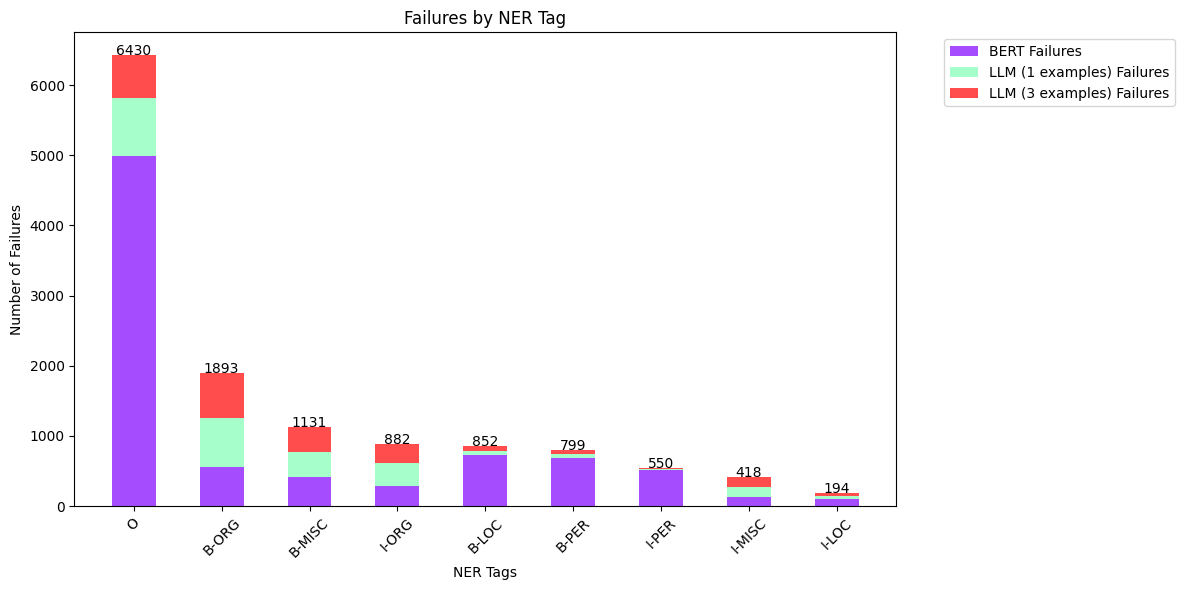

In [33]:
plot_failed_ner_tags(results)